In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from google.colab import drive
from matplotlib.ticker import EngFormatter

# 1. Data overview

### Reading and Inspecting Data

In [ ]:
# define the path to the CSV file
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Pandas_Data_Mate/'13. Final project'/
%ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Pandas_Data_Mate/13. Final project
countries.csv  events.csv  products.csv


In [ ]:
# import the CSV file as a DataFrame
df_countries = pd.read_csv('countries.csv')
df_events = pd.read_csv('events.csv')
df_products = pd.read_csv('products.csv')

In [ ]:
df_countries.head()

,name,alpha-2,alpha-3,region,sub-region
0,Afghanistan,AF,AFG,Asia,Southern Asia
1,Åland Islands,AX,ALA,Europe,Northern Europe
2,Albania,AL,ALB,Europe,Southern Europe
3,Algeria,DZ,DZA,Africa,Northern Africa
4,American Samoa,AS,ASM,Oceania,Polynesia


In [ ]:
df_events.head()

,Order ID,Order Date,Ship Date,Order Priority,Country Code,Product ID,Sales Channel,Units Sold,Unit Price,Unit Cost
0,100640618,10/8/2014,10/18/2014,M,NOR,2103,Online,650.0,205.70,117.11
1,100983083,8/11/2016,8/11/2016,C,SRB,2103,Offline,1993.0,205.70,117.11
2,101025998,7/18/2014,8/11/2014,M,NaN,7940,Online,4693.0,668.27,502.54
3,102230632,5/13/2017,6/13/2017,L,MNE,2455,Online,1171.0,109.28,35.84
4,103435266,8/11/2012,9/18/2012,H,SRB,1270,Offline,7648.0,47.45,31.79


In [ ]:
df_products.head()

,id,item_type
0,2103,Cereal
1,7940,Household
2,2455,Clothes
3,1270,Beverages
4,8681,Office Supplies


In [ ]:
print(df_countries.info())
print(df_events.info())
print(df_products.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        249 non-null    object
 1   alpha-2     248 non-null    object
 2   alpha-3     249 non-null    object
 3   region      248 non-null    object
 4   sub-region  248 non-null    object
dtypes: object(5)
memory usage: 9.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330 entries, 0 to 1329
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order ID        1330 non-null   int64  
 1   Order Date      1330 non-null   object 
 2   Ship Date       1330 non-null   object 
 3   Order Priority  1330 non-null   object 
 4   Country Code    1248 non-null   object 
 5   Product ID      1330 non-null   int64  
 6   Sales Channel   1330 non-null   object 
 7   Units Sold      1328 non-null   float64
 8   Unit Pric

In [ ]:
# renaming columns according to snake_case
df_countries.columns = df_countries.columns.str.replace('-', '_')
df_events.columns = df_events.columns.str.lower().str.replace(' ', '_')

### Dataset Structure

This dataset contains information about international sales, products, and countries. It consists of three connected tables:

##### 1. Countries Table
* `name`: Full country name
* `alpha_2`: 2-letter country code
* `alpha_3`: 3-letter country code
* `region`: Geographical region
* `sub_region`: More specific sub-region

**Rows**: 249

##### 2. Events Table (Main table)
* `order_id`: Unique order identifier
* `order_date`, `ship_date`: Order and shipping dates
* `order_priority`: Priority level of the order
* `country_code`: 3-letter country code
* `product_id`: ID of the purchased product
* `sales_channel`: Sales platform or method
* `units_sold`: Number of items sold
* `unit_price`: Price per unit
* `unit_cost`: Cost per unit

**Rows**: 1330

##### 3. Products Table
* `id`: Product identifier
* `item_type`: Type of the product

**Rows**: 12


##### Table Relationships

* df_events.product_id  --  df_products.id
* df_events.country_code  --  df_countries.alpha-3

# 2. Data cleaning

### Missing Data Overview

In [ ]:
df_countries.isna().sum()

,0
name,0
alpha_2,1
alpha_3,0
region,1
sub_region,1


In [ ]:
df_events.isna().sum()

,0
order_id,0
order_date,0
ship_date,0
order_priority,0
country_code,82
product_id,0
sales_channel,0
units_sold,2
unit_price,0
unit_cost,0


In [ ]:
df_products.isna().sum()

,0
id,0
item_type,0


In [ ]:
df_countries.isna().sum() / df_countries.shape[0] * 100

,0
name,0.000000
alpha_2,0.401606
alpha_3,0.000000
region,0.401606
sub_region,0.401606


In [ ]:
df_events.isna().sum() / df_events.shape[0] * 100

,0
order_id,0.000000
order_date,0.000000
ship_date,0.000000
order_priority,0.000000
country_code,6.165414
product_id,0.000000
sales_channel,0.000000
units_sold,0.150376
unit_price,0.000000
unit_cost,0.000000


### Missing Data Handling

- In the **Countries** table, about **0.4%** of the rows are missing values in the `alpha_2`, `region` and `sub_region` columns.\
Missing columns may be due to incomplete or disputed geopolitical data for certain territories.\
We **cannot delete these rows** because doing so we would remove values of `alpha_3`, which is a primary key.\
Since these fields **are not part of the primary key**, we will fill missing values with *'Unknown'*.

- In the **Events** table, the `country_code` column — which acts as a **foreign key** to the Countries table — is missing in **6.17%** of the rows.\
Missing values may indicate partially recorded orders or technical issues during data import/export.\
These rows **cannot be dropped** as they contain essential order data. We will fill the missing country codes with *'Unknown'* as well and keep this in mind during analysis and visualization, since some orders have no associated country information.\
Additionally, we have **0.15%** missing values in the `units_sold` column, which could significantly affect our analysis and visualization; therefore, we will **remove those rows**.

- The **Products** table doesn't contain missing values, so no action is needed.

In [ ]:
df_countries[['alpha_2', 'region', 'sub_region']] = df_countries[['alpha_2', 'region', 'sub_region']].fillna('Unknown')
df_countries.isna().sum()

,0
name,0
alpha_2,0
alpha_3,0
region,0
sub_region,0


In [ ]:
df_events['country_code'] = df_events['country_code'].fillna('Unknown')
df_events = df_events.dropna()
df_events.isna().sum()

,0
order_id,0
order_date,0
ship_date,0
order_priority,0
country_code,0
product_id,0
sales_channel,0
units_sold,0
unit_price,0
unit_cost,0


### Data Types and Dublicates


The Events table has three columns with incorrect data types: `order_date`, `ship_date` and `units_sold`. We will convert first two columns to datetime format and third one to int.

In [ ]:
df_events['order_date'] = pd.to_datetime(df_events['order_date'])
df_events['ship_date'] = pd.to_datetime(df_events['ship_date'])
df_events['units_sold'] = df_events['units_sold'].astype(int)
df_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1328 entries, 0 to 1329
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   order_id        1328 non-null   int64         
 1   order_date      1328 non-null   datetime64[ns]
 2   ship_date       1328 non-null   datetime64[ns]
 3   order_priority  1328 non-null   object        
 4   country_code    1328 non-null   object        
 5   product_id      1328 non-null   int64         
 6   sales_channel   1328 non-null   object        
 7   units_sold      1328 non-null   int64         
 8   unit_price      1328 non-null   float64       
 9   unit_cost       1328 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(3), object(3)
memory usage: 114.1+ KB


In [ ]:
print(df_countries.duplicated().sum())
print(df_events.duplicated().sum())
print(df_products.duplicated().sum())

0
0
0


Also the `sales_channel` column contains inconsistent casing within the same category. Let's standardize all values to a single case format to ensure consistency and improve data quality.

In [ ]:
df_events['sales_channel'] = df_events['sales_channel'].str.title()
df_events['sales_channel'].unique()

array(['Online', 'Offline'], dtype=object)

### Anomalies

In [ ]:
df_events.describe()

,order_id,order_date,ship_date,product_id,units_sold,unit_price,unit_cost
count,1.328000e+03,1328,1328,1328.000000,1328.000000,1328.000000,1328.000000
mean,5.416231e+08,2013-10-11 22:28:54.939759104,2013-11-05 17:22:02.891566336,5787.775602,4952.201807,264.913245,187.211521
min,1.006406e+08,2010-01-01 00:00:00,2010-01-10 00:00:00,1270.000000,2.000000,9.330000,6.920000
25%,3.213291e+08,2011-12-14 06:00:00,2012-01-02 00:00:00,3127.000000,2356.750000,81.730000,35.840000
50%,5.399925e+08,2013-10-15 12:00:00,2013-11-05 12:00:00,5988.000000,4962.000000,154.060000,97.440000
75%,7.547357e+08,2015-08-29 12:00:00,2015-10-04 18:00:00,8681.000000,7459.500000,437.200000,263.330000
max,9.998797e+08,2017-07-23 00:00:00,2017-08-31 00:00:00,8969.000000,9999.000000,668.270000,524.960000
std,2.573496e+08,NaN,NaN,2820.635702,2905.198996,217.386320,176.187801


In [ ]:
invalid_dates = df_events[df_events['ship_date'] < df_events['order_date']]
invalid_dates

,order_id,order_date,ship_date,order_priority,country_code,product_id,sales_channel,units_sold,unit_price,unit_cost


There are no invalid dates: the shipping date is always later than the order date

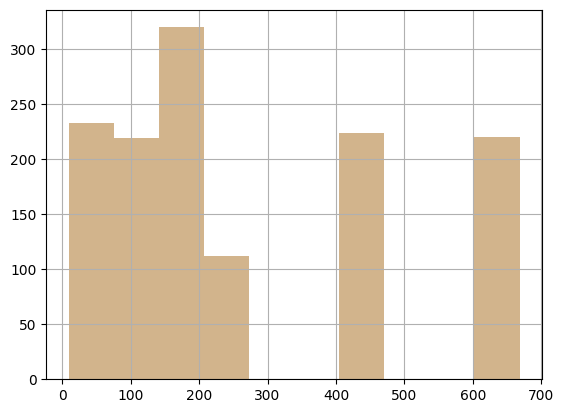

In [ ]:
df_events['unit_price'].hist(color='tan')
plt.show()

There are no outliers in `unit_price` distribution. Most values are closer to the lower prices, with a few high ones. This is a normal pattern.

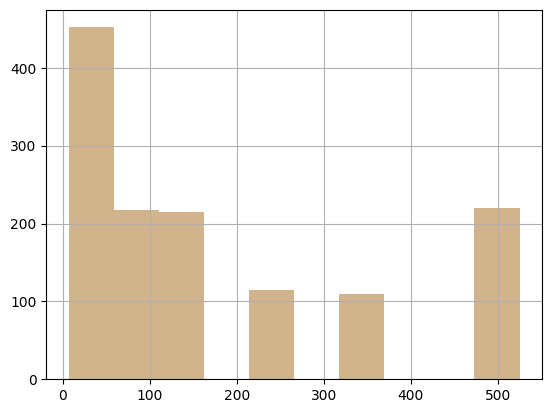

In [ ]:
df_events['unit_cost'].hist(color='tan')
plt.show()

There are no outliers in `unit_cost` distribution. Most values are closer to the lower prices, with a few high ones. This is a normal pattern.

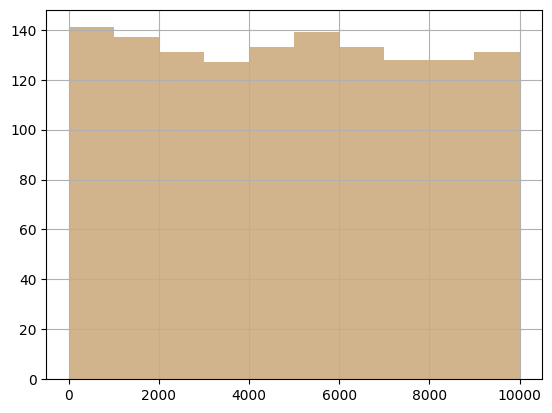

In [ ]:
df_events['units_sold'].hist(color='tan')
plt.show()

The distribution of `units_sold` is almost flat — values are spread evenly.
There are no clear outliers, and the data looks well-balanced.

# 3. Data analysis and visualization

### Data merging

In [ ]:
df_events.head()

,order_id,order_date,ship_date,order_priority,country_code,product_id,sales_channel,units_sold,unit_price,unit_cost
0,100640618,2014-10-08,2014-10-18,M,NOR,2103,Online,650,205.70,117.11
1,100983083,2016-08-11,2016-08-11,C,SRB,2103,Offline,1993,205.70,117.11
2,101025998,2014-07-18,2014-08-11,M,Unknown,7940,Online,4693,668.27,502.54
3,102230632,2017-05-13,2017-06-13,L,MNE,2455,Online,1171,109.28,35.84
4,103435266,2012-08-11,2012-09-18,H,SRB,1270,Offline,7648,47.45,31.79


In [ ]:
df_countries.head()

,name,alpha_2,alpha_3,region,sub_region
0,Afghanistan,AF,AFG,Asia,Southern Asia
1,Åland Islands,AX,ALA,Europe,Northern Europe
2,Albania,AL,ALB,Europe,Southern Europe
3,Algeria,DZ,DZA,Africa,Northern Africa
4,American Samoa,AS,ASM,Oceania,Polynesia


In [ ]:
events_and_countries = pd.merge(df_events, df_countries, how='left', left_on='country_code', right_on='alpha_3')
df = pd.merge(events_and_countries, df_products, how='left', left_on='product_id', right_on='id')
df = df.drop(['alpha_3', 'id', 'alpha_2'], axis=1)
df = df.rename(columns={'name': 'country_name'})
df[['country_name', 'region', 'sub_region']] = df[['country_name', 'region', 'sub_region']].fillna('Unknown')
df.head()

,order_id,order_date,ship_date,order_priority,country_code,product_id,sales_channel,units_sold,unit_price,unit_cost,country_name,region,sub_region,item_type
0,100640618,2014-10-08,2014-10-18,M,NOR,2103,Online,650,205.70,117.11,Norway,Europe,Northern Europe,Cereal
1,100983083,2016-08-11,2016-08-11,C,SRB,2103,Offline,1993,205.70,117.11,Serbia,Europe,Southern Europe,Cereal
2,101025998,2014-07-18,2014-08-11,M,Unknown,7940,Online,4693,668.27,502.54,Unknown,Unknown,Unknown,Household
3,102230632,2017-05-13,2017-06-13,L,MNE,2455,Online,1171,109.28,35.84,Montenegro,Europe,Southern Europe,Clothes
4,103435266,2012-08-11,2012-09-18,H,SRB,1270,Offline,7648,47.45,31.79,Serbia,Europe,Southern Europe,Beverages


### Main Metrics

In [ ]:
df['unit_profit'] = df['unit_price'] - df['unit_cost']

print(df.shape[0])
print(len(df['country_name'].unique()))
print((df['unit_price'] * df['units_sold']).sum())
print((df['unit_profit'] * df['units_sold']).sum())
print(len(df['product_id'].unique()))


1328
46
1702129408.21
501434459.0
12


**Main metrics**
- Order quantity: 1328
- Countries quantity: 45
- Total revenue: \$1 702 129 408.21
- Total profit: \$501 434 459.0
- Product quantity: 12


### Analysis by Category

In [ ]:
df['revenue'] = df['units_sold'] * df['unit_price']
df['profit'] = df['units_sold'] * df['unit_profit']
df['cost'] = df['units_sold'] * df['unit_cost']

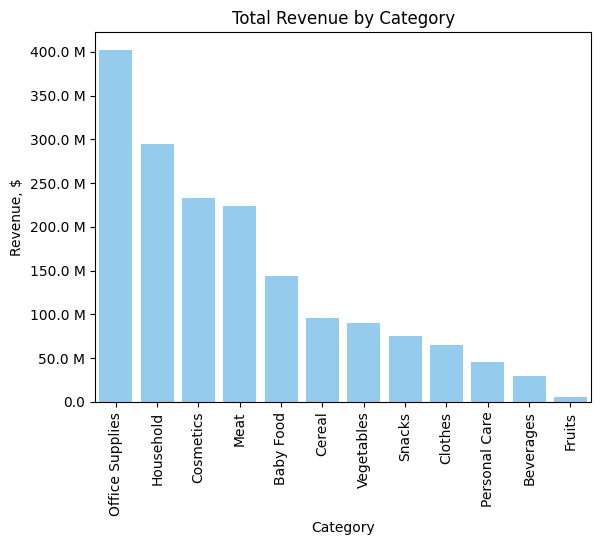

In [ ]:
revenue_by_cat = df[['revenue', 'item_type']].groupby('item_type')['revenue'].sum().reset_index()
revenue_by_cat = revenue_by_cat.sort_values(by='revenue', ascending=False)

sns.barplot(revenue_by_cat, x='item_type', y='revenue', color='lightskyblue')
plt.xticks(rotation=90)
plt.title('Total Revenue by Category')
plt.xlabel('Category')
plt.ylabel('Revenue, $')

plt.gca().yaxis.set_major_formatter(EngFormatter(places=1))

plt.show()

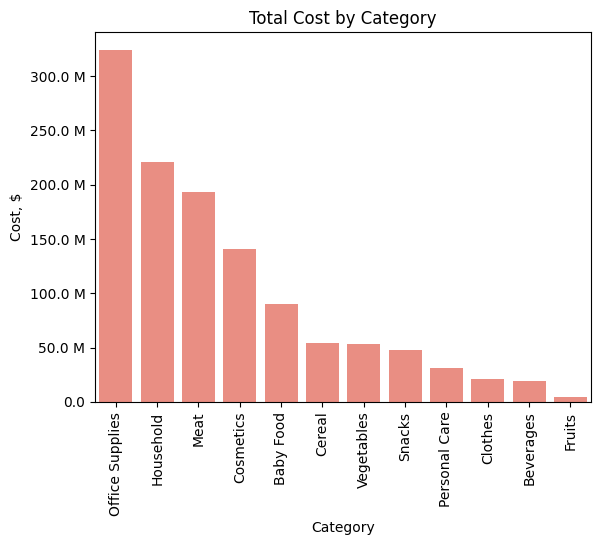

In [ ]:
cost_by_cat = df[['cost', 'item_type']].groupby('item_type')['cost'].sum().reset_index()
cost_by_cat = cost_by_cat.sort_values(by='cost', ascending=False)

sns.barplot(cost_by_cat, x='item_type', y='cost', color='salmon')
plt.xticks(rotation=90)
plt.title('Total Cost by Category')
plt.xlabel('Category')
plt.ylabel('Cost, $')

plt.gca().yaxis.set_major_formatter(EngFormatter(places=1))

plt.show()

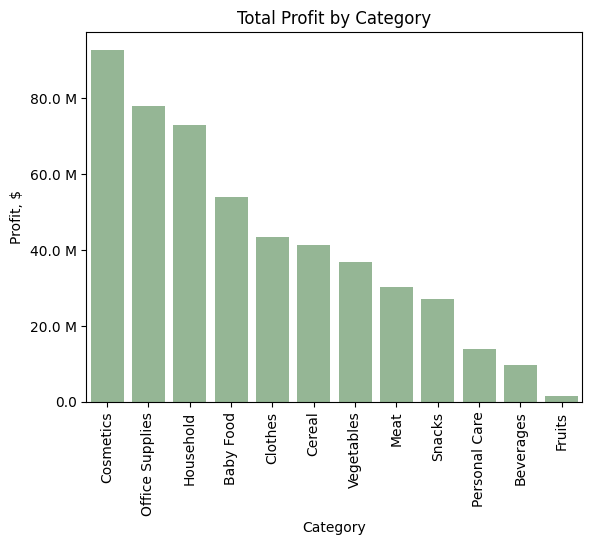

In [ ]:
profit_by_cat = df[['profit', 'item_type']].groupby('item_type')['profit'].sum().reset_index()
profit_by_cat = profit_by_cat.sort_values(by='profit', ascending=False)

sns.barplot(profit_by_cat, x='item_type', y='profit', color='darkseagreen')
plt.xticks(rotation=90)
plt.title('Total Profit by Category')
plt.xlabel('Category')
plt.ylabel('Profit, $')

plt.gca().yaxis.set_major_formatter(EngFormatter(places=1))

plt.show()

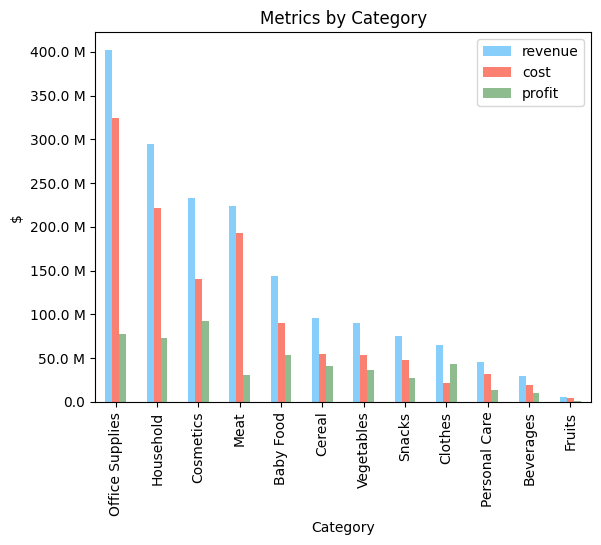

In [ ]:
grouped_by_cat = pd.DataFrame({
    'item_type': revenue_by_cat['item_type'],
    'revenue': revenue_by_cat['revenue'],
    'cost': cost_by_cat['cost'],
    'profit': profit_by_cat['profit']
}).sort_values(by='revenue', ascending=False)
grouped_by_cat.set_index('item_type', inplace=True)

grouped_by_cat.plot(kind='bar', stacked=False, color=['lightskyblue', 'salmon', 'darkseagreen'])
plt.xticks(rotation=90)
plt.title('Metrics by Category')
plt.xlabel('Category')
plt.ylabel('$')

plt.gca().yaxis.set_major_formatter(EngFormatter(places=1))

plt.show()

1. Revenue
- Top Revenue: Office Supplies — the highest revenue, exceeding \$400 million.
- Mid-Level Revenue: Household, Cosmetics, Meat, Baby Food — substantial revenue, though below the top category.
- Low Revenue: Fruits, Beverages, Personal Care — each generates less than \$50 million.
2. Cost
- High Costs: Office Supplies, Household and Meat — expenses nearly match revenue, indicating potentially low profit margins.
- Moderate Costs: Cosmetics, Baby Food — costs are lower than revenue, allowing room for profitability.
- Low Costs: Fruits, Beverages — minimal expenses, but also limited revenue.
3. Profit
- Most Profitable Categories: Office Supplies, Household, Cosmetics, Baby Food — clear gap between revenue and cost, resulting in strong profits.
- Minimal Profit: Meat, Fruits, Beverages, Personal Care — low profitability driven by limited revenue.

\
Despite generating high revenue, Office Supplies and Household exhibit relatively low profit margins when compared to their product costs. In contrast, Cosmetics demonstrates a more efficient cost structure, yielding higher profits from lower expenditures.\
The Meat category appears notably unprofitable — while revenue is high, it is offset by equally high costs, resulting in minimal net profit.\
A particularly promising category is Clothes, where the metrics show a favorable balance: although revenue is modest, the exceptionally low costs lead to profits that exceed expenses. This suggests potential for strategic focus and increased promotion of this category.

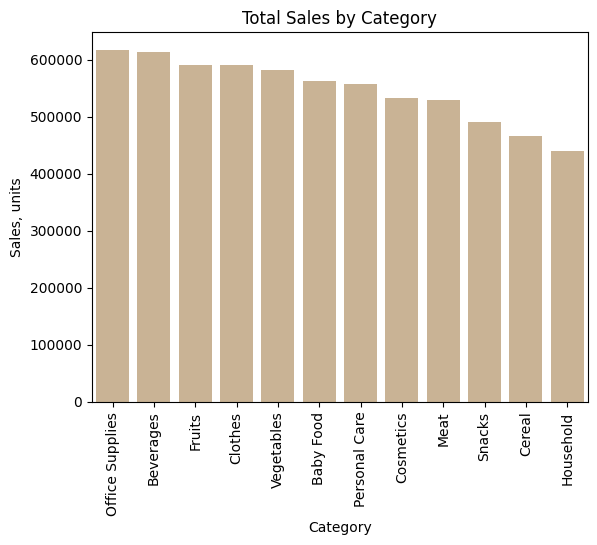

In [ ]:
product_by_cat = df[['item_type', 'units_sold']].groupby('item_type')['units_sold'].sum().reset_index()
product_by_cat = product_by_cat.sort_values(by='units_sold', ascending=False)

sns.barplot(product_by_cat, x='item_type', y='units_sold', color='tan')
plt.xticks(rotation=90)
plt.title('Total Sales by Category')
plt.xlabel('Category')
plt.ylabel('Sales, units')

plt.show()


Office Supplies are sold most often (over 600 000 sales) — they have the highest total sales. Household is sold least often (over 450 000 sales) — it has the lowest sales among all categories.\
However, the difference between them is not very large — most categories fall within a similar sales range (450 000 - 625 000).\
Let's compare this with profit data: Office Supplies, despite high sales, show around \$75M profit due to high costs. Household, with lower sales, still shows a relatively strong profit of about \$70M.

### Analysis by Country

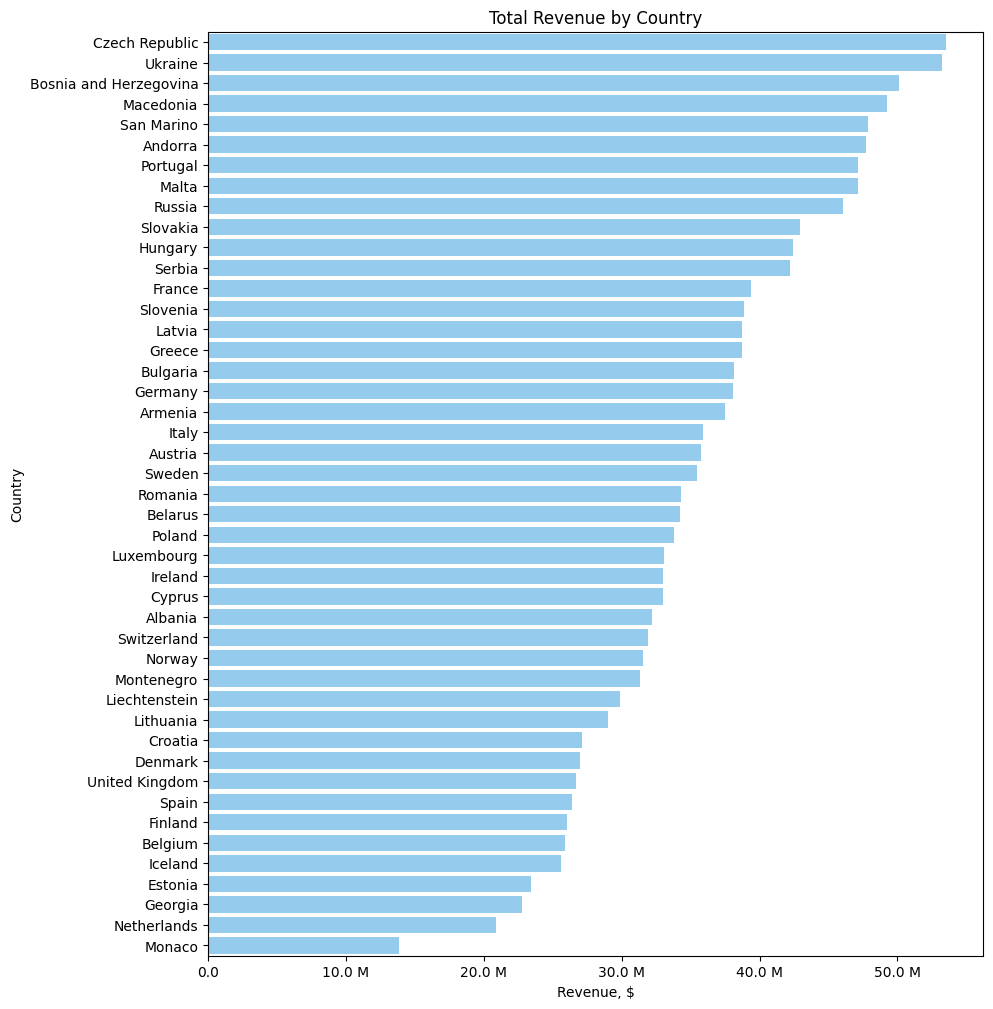

In [ ]:
revenue_by_country = df[df['country_name'] != 'Unknown'].groupby('country_name')['revenue'].sum().reset_index().sort_values(by='revenue', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(revenue_by_country, x='revenue', y='country_name', color='lightskyblue')
plt.title('Total Revenue by Country')
plt.xlabel('Revenue, $')
plt.ylabel('Country')

plt.gca().xaxis.set_major_formatter(EngFormatter(places=1))

plt.show()

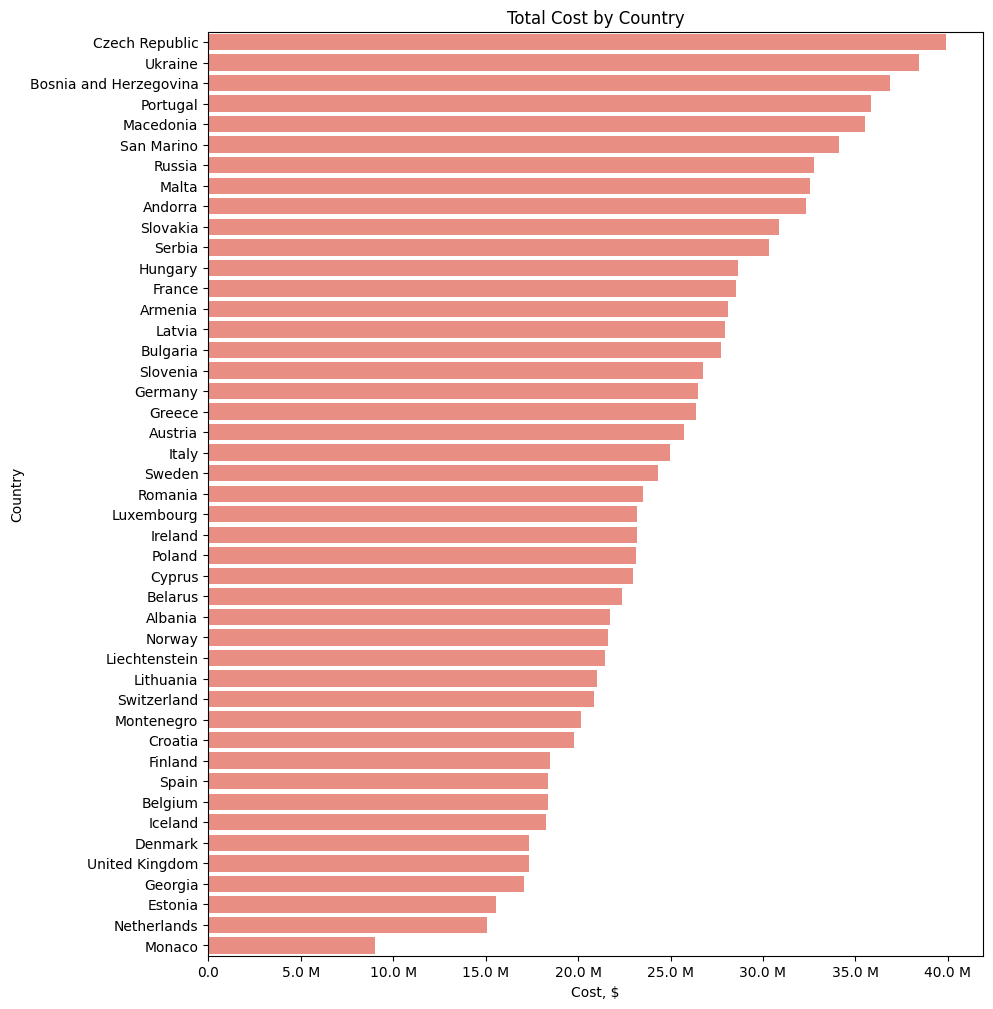

In [ ]:
cost_by_country = df[df['country_name'] != 'Unknown'].groupby('country_name')['cost'].sum().reset_index().sort_values(by='cost', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(cost_by_country, x='cost', y='country_name', color='salmon')
plt.title('Total Cost by Country')
plt.xlabel('Cost, $')
plt.ylabel('Country')

plt.gca().xaxis.set_major_formatter(EngFormatter(places=1))

plt.show()

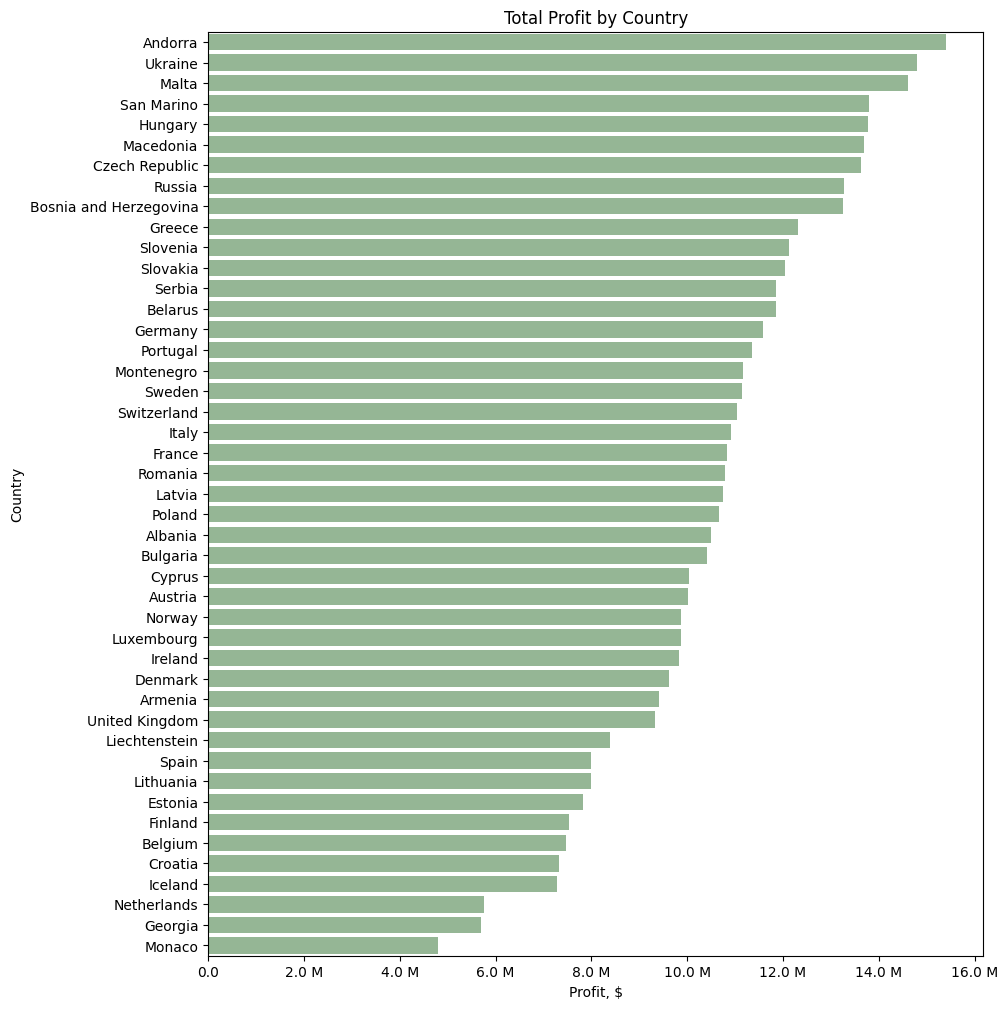

In [ ]:
profit_by_country = df[df['country_name'] != 'Unknown'].groupby('country_name')['profit'].sum().reset_index().sort_values(by='profit', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(profit_by_country, x='profit', y='country_name', color='darkseagreen')
plt.title('Total Profit by Country')
plt.xlabel('Profit, $')
plt.ylabel('Country')

plt.gca().xaxis.set_major_formatter(EngFormatter(places=1))

plt.show()

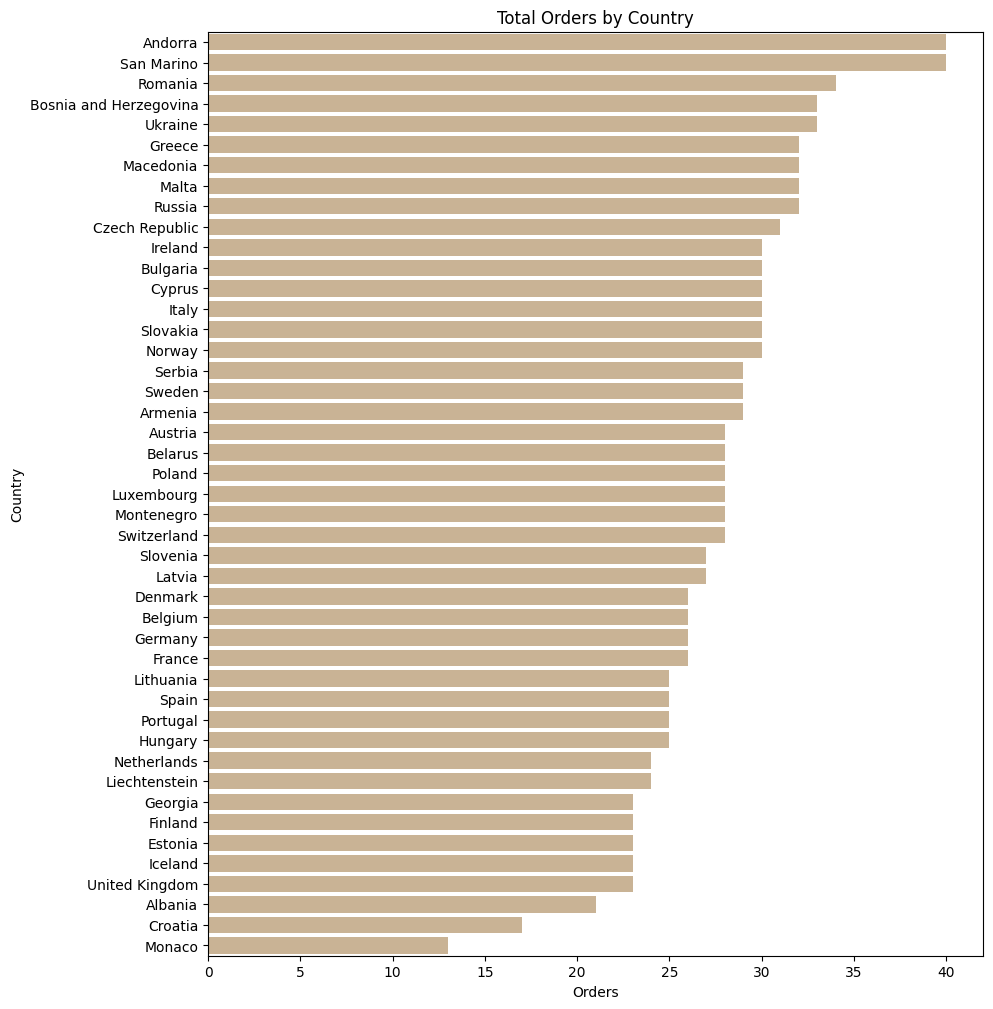

In [ ]:
sales_by_country = df[df['country_name'] != 'Unknown'].groupby('country_name')['order_id'].count().reset_index().sort_values(by='order_id', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(sales_by_country, x='order_id', y='country_name', color='tan')
plt.title('Total Orders by Country')
plt.xlabel('Orders')
plt.ylabel('Country')

plt.show()

#### Revenue and Cost Move Together
In both **Total Revenue** and **Total Cost**, we see **the same** top and bottom countries:
  - Czech Republic, Ukraine, Bosnia and Herzegovina have the highest revenue and also the highest costs. This means they work with large volumes and cost a lot.
  - Monaco, Georgia, Iceland are at the bottom in both metrics. These countries may have small markets or low business activity.

#### Sales vs. Profit
In **Total Profit** and **Total Sales**, the results are as follows:
- Andorra is in the top of both lists. It sells a lot and earns good profit — this shows strong efficiency. Also Ukraine, Malta and San Marino have not bad results.
- Again, Monaco is at the bottom — it sells little and earn little.

#### Conclusion
- Czech Republic has high revenue and cost, but is not very efficient in profit.
- Andorra is efficient — it is profitable without high costs.
- Monaco, Georgia, Iceland, Croatia have weak results in all metrics — possibly due to small markets or low demand.

### Analysis by Region

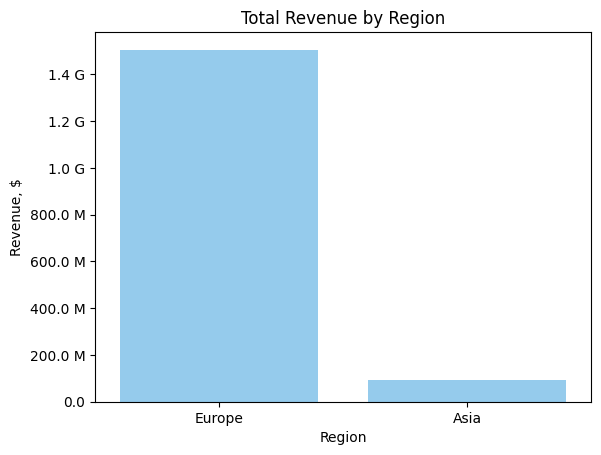

In [ ]:
revenue_by_region = df[df['region'] != 'Unknown'].groupby('region')['revenue'].sum().reset_index().sort_values(by='revenue', ascending=False)[:10]

sns.barplot(revenue_by_region, x='region', y='revenue', color='lightskyblue')
plt.title('Total Revenue by Region')
plt.xlabel('Region')
plt.ylabel('Revenue, $')

plt.gca().yaxis.set_major_formatter(EngFormatter(places=1))

plt.show()

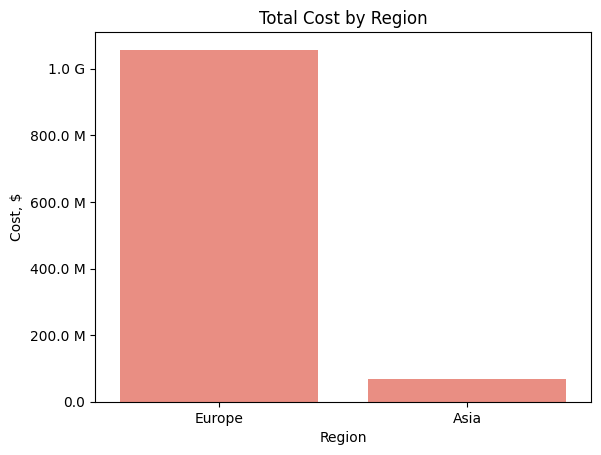

In [ ]:
cost_by_region = df[df['region'] != 'Unknown'].groupby('region')['cost'].sum().reset_index().sort_values(by='cost', ascending=False)[:10]

sns.barplot(cost_by_region, x='region', y='cost', color='salmon')
plt.title('Total Cost by Region')
plt.xlabel('Region')
plt.ylabel('Cost, $')

plt.gca().yaxis.set_major_formatter(EngFormatter(places=1))

plt.show()

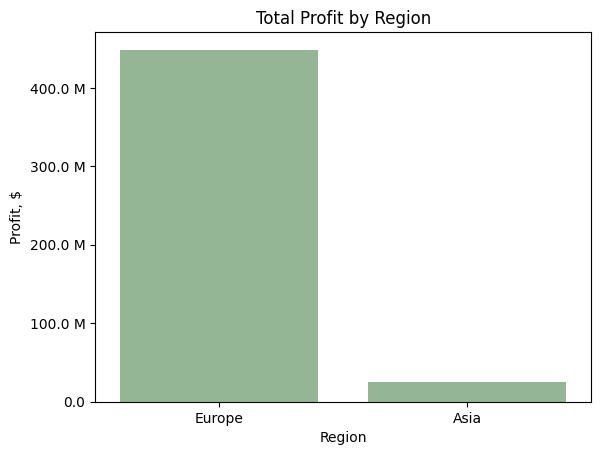

In [ ]:
profit_by_region = df[df['region'] != 'Unknown'].groupby('region')['profit'].sum().reset_index().sort_values(by='profit', ascending=False)[:10]

sns.barplot(profit_by_region, x='region', y='profit', color='darkseagreen')
plt.title('Total Profit by Region')
plt.xlabel('Region')
plt.ylabel('Profit, $')

plt.gca().yaxis.set_major_formatter(EngFormatter(places=1))

plt.show()

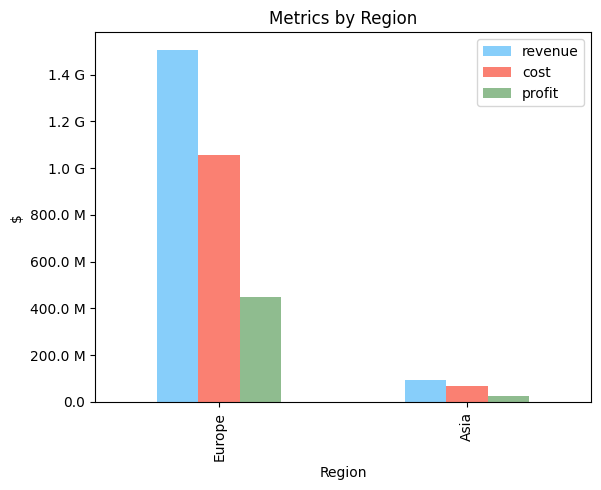

In [ ]:
grouped_by_region = pd.DataFrame({
    'region': revenue_by_region['region'],
    'revenue': revenue_by_region['revenue'],
    'cost': cost_by_region['cost'],
    'profit': profit_by_region['profit']
}).sort_values(by='revenue', ascending=False)
grouped_by_region.set_index('region', inplace=True)

grouped_by_region.plot(kind='bar', stacked=False, color=['lightskyblue', 'salmon', 'darkseagreen'])
plt.xticks(rotation=90)
plt.title('Metrics by Region')
plt.xlabel('Region')
plt.ylabel('$')

plt.gca().yaxis.set_major_formatter(EngFormatter(places=1))

plt.show()

Europe significantly outperforms Asia across all financial metrics — revenue, cost, and profit. Europe's revenue reaches around \$1.4 billion, while Asia's is below \$200 million. Despite higher costs, Europe maintains a strong profit of approximately \$600 million, indicating efficient business performance.

### Analysis by Sales Channel

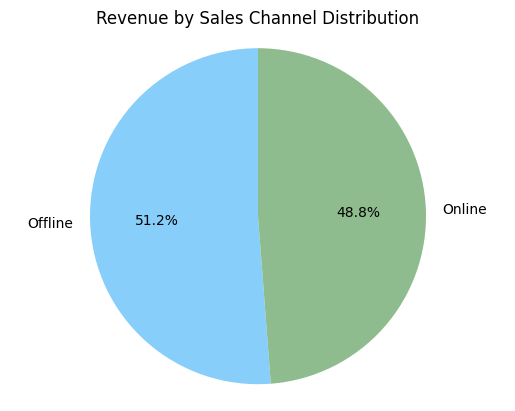

In [ ]:
revenue_by_channel = df.groupby('sales_channel')['revenue'].sum().reset_index()

plt.pie(x=revenue_by_channel['revenue'], labels=revenue_by_channel['sales_channel'], autopct='%1.1f%%', startangle=90, colors=['lightskyblue', 'darkseagreen'])
plt.axis('equal')
plt.title('Revenue by Sales Channel Distribution')
plt.show()

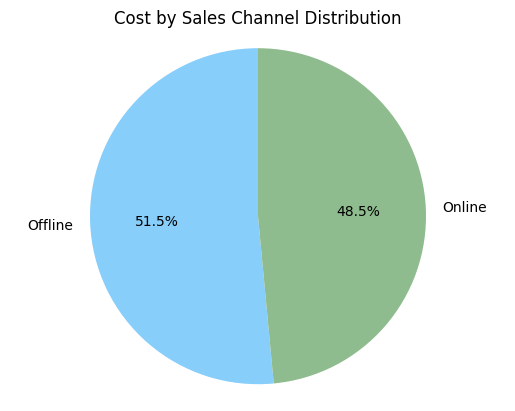

In [ ]:
cost_by_channel = df.groupby('sales_channel')['cost'].sum().reset_index()

plt.pie(x=cost_by_channel['cost'], labels=cost_by_channel['sales_channel'], autopct='%1.1f%%', startangle=90, colors=['lightskyblue', 'darkseagreen'])
plt.axis('equal')
plt.title('Cost by Sales Channel Distribution')
plt.show()

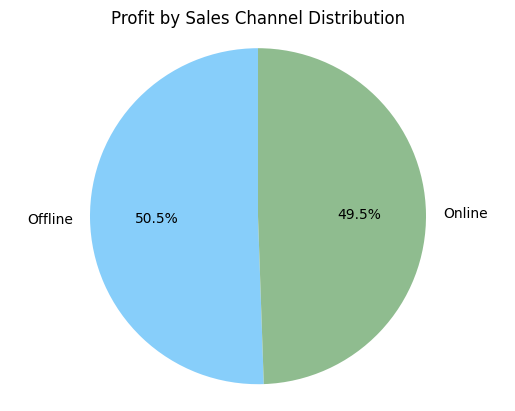

In [ ]:
profit_by_channel = df.groupby('sales_channel')['profit'].sum().reset_index()

plt.pie(x=profit_by_channel['profit'], labels=profit_by_channel['sales_channel'], autopct='%1.1f%%', startangle=90, colors=['lightskyblue', 'darkseagreen'])
plt.axis('equal')
plt.title('Profit by Sales Channel Distribution')
plt.show()

The distribution across Offline and Online sales channels is nearly balanced for revenue, cost, and profit, with Offline slightly leading in each metric. This suggests both channels contribute almost equally to overall business performance.

### Order-to-Ship analysis

In [ ]:
df['order_to_ship'] = (df['ship_date'] - df['order_date']).dt.days

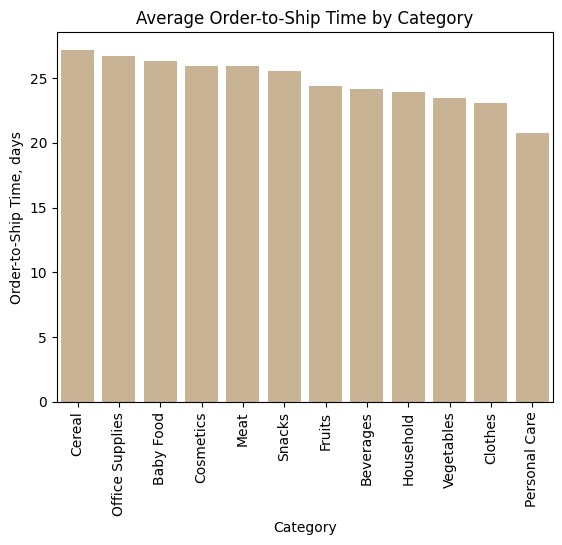

In [ ]:
ship_time_by_category = df[['order_to_ship', 'item_type']].groupby('item_type')['order_to_ship'].agg(['min', 'mean', 'max']).reset_index().sort_values(by='mean', ascending=False)

sns.barplot(ship_time_by_category, x='item_type', y='mean', color='tan')
plt.xticks(rotation=90)
plt.title('Average Order-to-Ship Time by Category')
plt.xlabel('Category')
plt.ylabel('Order-to-Ship Time, days')

plt.show()

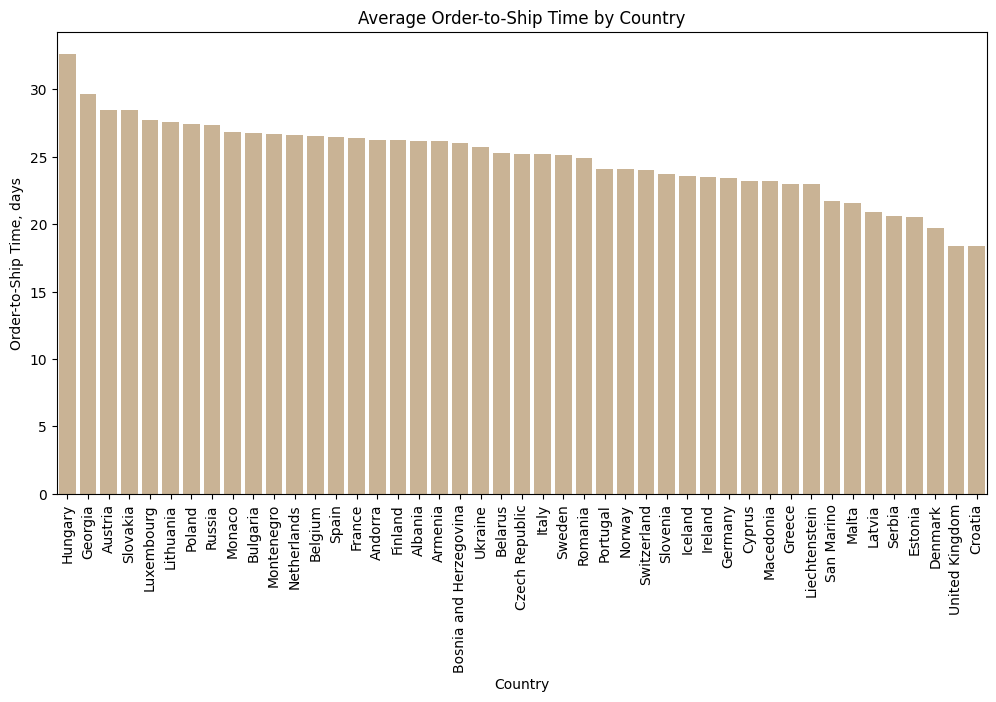

In [ ]:
ship_time_by_country = df[df['country_name'] != 'Unknown']
ship_time_by_country = ship_time_by_country[['order_to_ship', 'country_name']].groupby('country_name')['order_to_ship'].agg(['min', 'mean', 'max']).reset_index().sort_values(by='mean', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(ship_time_by_country, x='country_name', y='mean', color='tan')
plt.xticks(rotation=90)
plt.title('Average Order-to-Ship Time by Country')
plt.xlabel('Country')
plt.ylabel('Order-to-Ship Time, days')

plt.show()

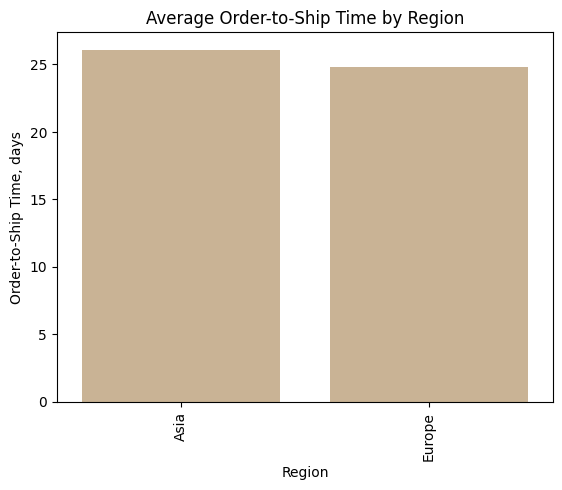

In [ ]:
ship_time_by_region = df[df['region'] != 'Unknown']
ship_time_by_region = ship_time_by_region[['order_to_ship', 'region']].groupby('region')['order_to_ship'].agg(['min', 'mean', 'max']).reset_index().sort_values(by='mean', ascending=False)

sns.barplot(ship_time_by_region, x='region', y='mean', color='tan')
plt.xticks(rotation=90)
plt.title('Average Order-to-Ship Time by Region')
plt.xlabel('Region')
plt.ylabel('Order-to-Ship Time, days')

plt.show()

We analyzed how long in average it takes to ship orders across different categories, countries, and regions. This helps us understand where shipping is fast and where it is slow.
- By Category

The slowest categories are Cereal, Office Supplies, Baby Food, and Cosmetics — they take the longest time to ship.\
The fastest category is Personal Care — it has the shortest shipping time.\
This may mean that some products need more preparation or packaging before shipping.
- By Country

Hungary, Georgia, Austria have the longest average shipping times — over 30 days.\
Croatia, United Kingdom, Denmark have the shortest times — around 20 days or less.\
Countries with slower shipping may have delays in logistics or longer processing times.
- By Region

Both Asia and Europe have similar average shipping times — about 25 days.\
This shows that regional differences are small, but country-level differences are more important.
- Conclusion

Product type affects shipping speed — some categories take longer to prepare.\
Country-level logistics and systems play a big role in shipping time.\
Europe and Asia are similar in average speed, but individual countries vary

### Correlation analysis: Profit VS Order-to-Ship Time

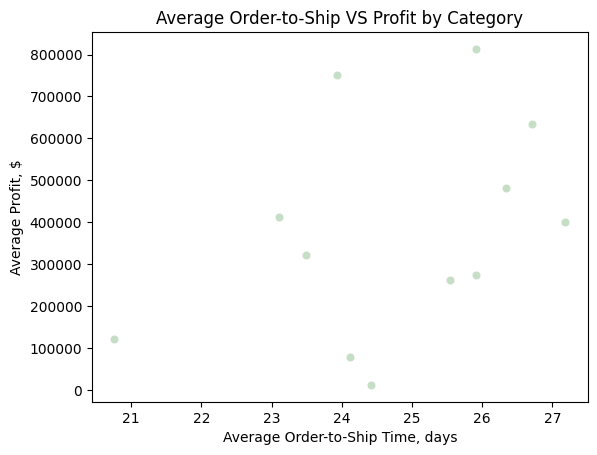

In [ ]:
ship_profit_category = df.groupby('item_type')[['profit', 'order_to_ship']].mean().reset_index()

sns.scatterplot(ship_profit_category, x='order_to_ship', y='profit', alpha=0.5, color='darkseagreen')
plt.title('Average Order-to-Ship VS Profit by Category')
plt.xlabel('Average Order-to-Ship Time, days')
plt.ylabel('Average Profit, $')
plt.show()

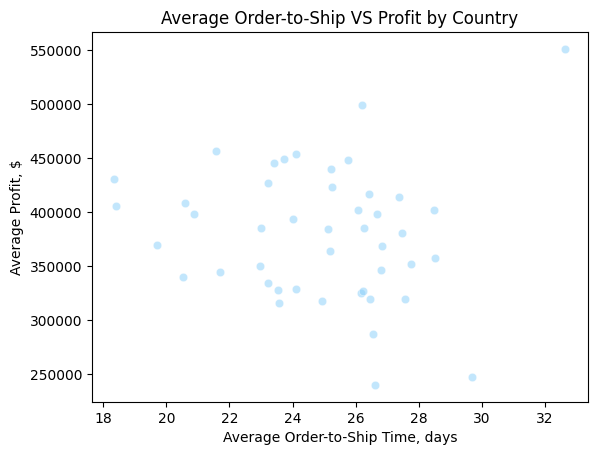

In [ ]:
ship_profit_country = df[df['country_name'] != 'Unknown'].groupby('country_name')[['profit', 'order_to_ship']].mean().reset_index()

sns.scatterplot(ship_profit_country, x='order_to_ship', y='profit', alpha=0.5, color='lightskyblue')
plt.title('Average Order-to-Ship VS Profit by Country')
plt.xlabel('Average Order-to-Ship Time, days')
plt.ylabel('Average Profit, $')
plt.show()

We analyzed the relationship between average order-to-ship time and average profit by both category and country.
- By Category

The scatter plot shows no strong pattern — categories with longer shipping times do not always have lower or higher profit.
This means shipping time may not directly affect profit at the category level.
- By Country

The country-level plot also shows a weak or no clear trend.
Some countries with short shipping times have high profit, but others with longer times also show good profit.\
\
There is no strong correlation between shipping time and profit in this dataset.

### Sales dynamics analysis

In [ ]:
# choosing only top-3 category by sales
product_by_cat['item_type'][:3]

,item_type
8,Office Supplies
1,Beverages
5,Fruits


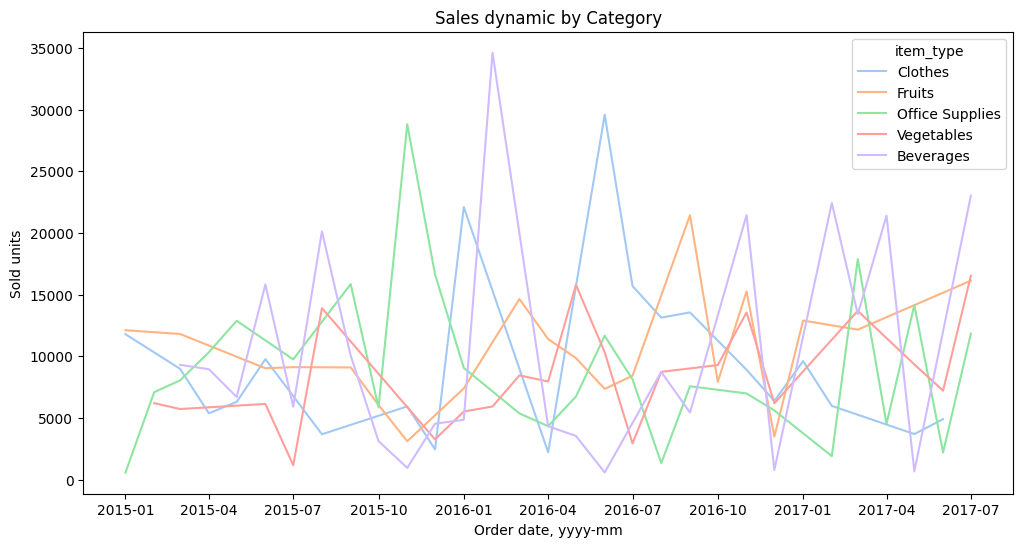

In [ ]:
dynamic_sales_by_category = df[['order_date', 'item_type', 'units_sold']].copy()
dynamic_sales_by_category = dynamic_sales_by_category[dynamic_sales_by_category['item_type'].isin(product_by_cat['item_type'][:5])]
dynamic_sales_by_category['order_by_month'] = df['order_date'].dt.to_period('M').dt.to_timestamp()
dynamic_sales_by_category = dynamic_sales_by_category[dynamic_sales_by_category['order_by_month'] >= '2015-01']
dynamic_sales_by_category = dynamic_sales_by_category.groupby(['order_by_month', 'item_type'])['units_sold'].sum().reset_index()
dynamic_sales_by_category

plt.figure(figsize=(12, 6))

sns.lineplot(dynamic_sales_by_category, x='order_by_month', y='units_sold', hue='item_type', palette='pastel')
plt.title('Sales dynamic by Category')
plt.xlabel('Order date, yyyy-mm')
plt.ylabel('Sold units')
plt.show()

Over the last 3 years (2015-2017), we analyzed the sales dynamics of the 5 most popular item categories.

- Office Supplies have irregular sales. There are some high periods (like in mid-2016), but no clear seasonality. In 2017, sales were more stable and lower than before.
- Beverages sales do not show stable seasonality during summer months. Sales peaks appear irregularly — for example, there was an unusual spike in February 2017, which does not follow the typical summer pattern.
- Clothes have a growing trend. Sales are high in January (maybe due to discounts) and also rise in summer (possibly from wardrobe updates).
- Fruits and Vegetables have stable sales all year. Vegetables are a bit less popular than Fruits.

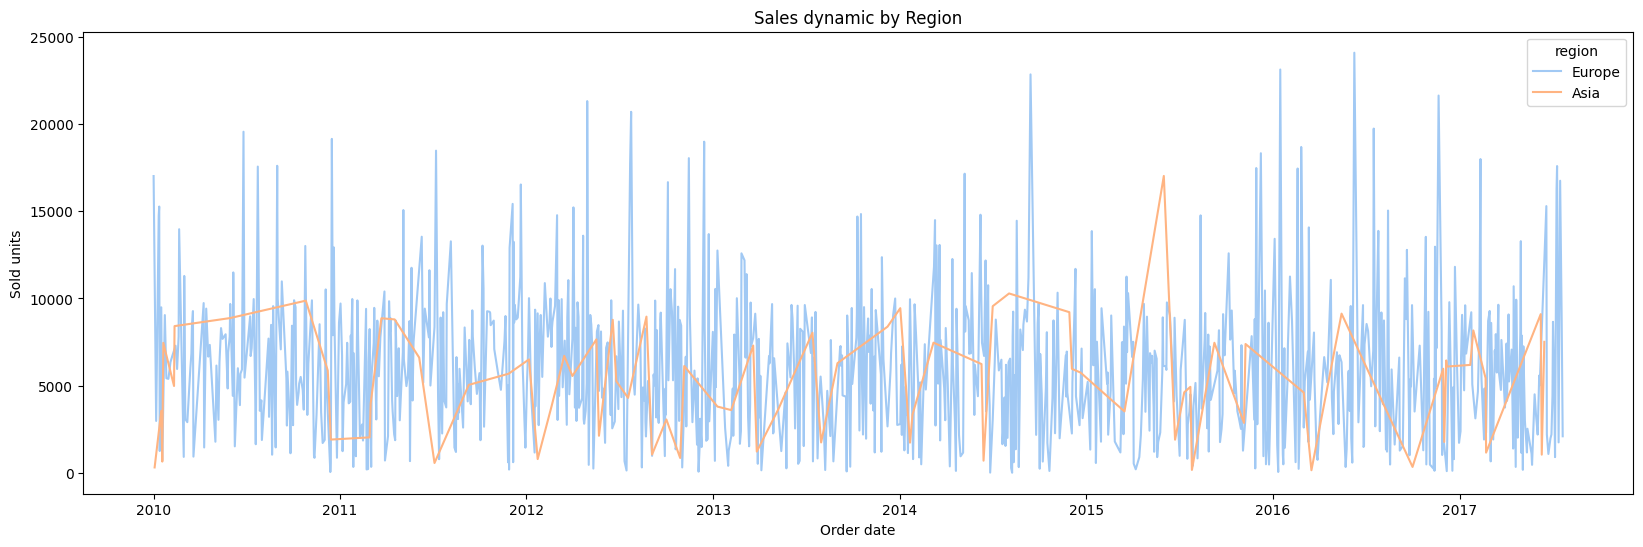

In [ ]:
dynamic_sales_by_region = df[df['region'] != 'Unknown']
dynamic_sales_by_region = dynamic_sales_by_region[['order_date', 'item_type', 'units_sold', 'region']].groupby(['order_date', 'region'])['units_sold'].sum().reset_index()

plt.figure(figsize=(20, 6))

sns.lineplot(dynamic_sales_by_region, x='order_date', y='units_sold', hue='region', palette='pastel')
plt.title('Sales dynamic by Region')
plt.xlabel('Order date')
plt.ylabel('Sold units')
plt.show()

Sales dynamics by Region

1. Europe
Sales happen frequently — almost every month. There are strong fluctuations, which may show seasonality or changes in demand. The overall sales level is constantly high, which shows the key role of the region in the business.
2. Asia
Sales are less frequent, but there are clear peaks in some periods. Maybe the data comes irregularly or the market is still growing. There is a trend of growth in some years, which may show potential for expansion.

### Sales by Weekday

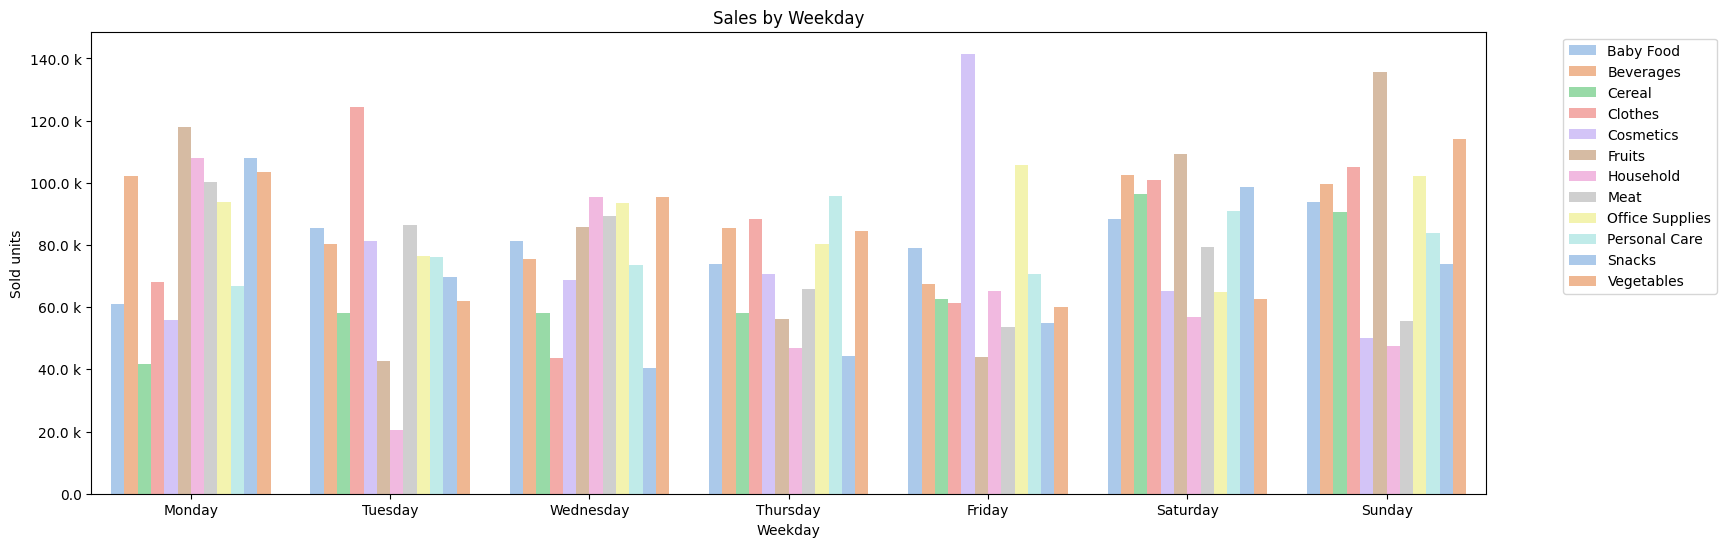

In [ ]:
sales_by_weekday = df[['order_date', 'item_type', 'units_sold']].copy()
sales_by_weekday['order_day'] = sales_by_weekday['order_date'].dt.day_name()
sales_by_weekday = sales_by_weekday.groupby(['order_day', 'item_type'])['units_sold'].sum().reset_index()
sales_by_weekday

plt.figure(figsize=(18, 6))

sns.barplot(sales_by_weekday, x='order_day', y='units_sold', hue='item_type', palette='pastel', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Sales by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Sold units')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().yaxis.set_major_formatter(EngFormatter(places=1))

plt.show()

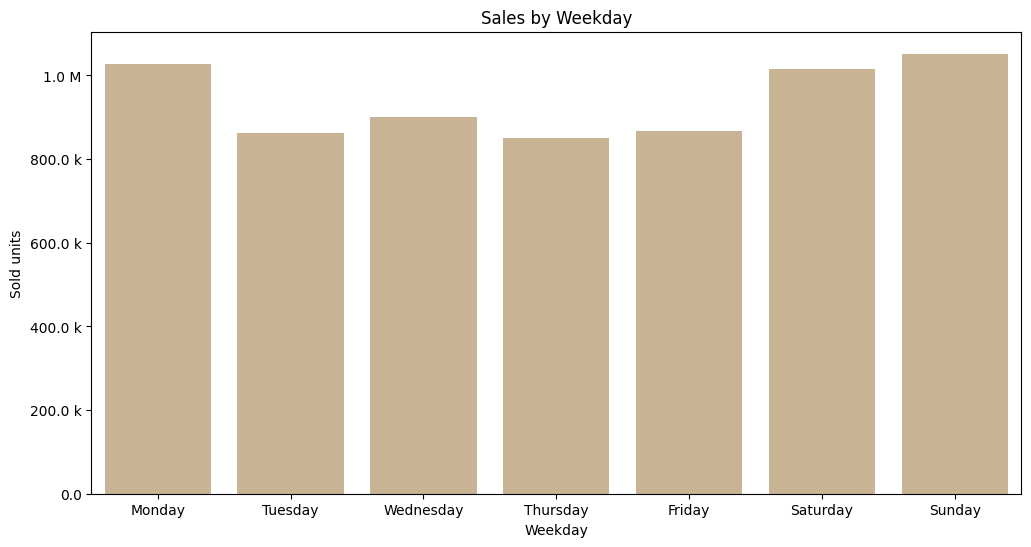

In [ ]:
plt.figure(figsize=(12, 6))

sns.barplot(sales_by_weekday, x='order_day', y='units_sold', color='tan', estimator='sum', errorbar=None, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Sales by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Sold units')

plt.gca().yaxis.set_major_formatter(EngFormatter(places=1))

plt.show()

1. Total Sales by Weekday

- Sales are highest on Monday, Saturday, Sunday.
- Weekends: more drinks, fruits, vegetables, snacks.
- Monday: more home and office products.
- Thursday: lowest sales.

2. Category Sales by Weekday

- Weekends: food and drinks grow.
- Monday: home and office goods grow.
- Clothes and cosmetics peak Tuesday and Saturday.

3. Conclusion

- Sales are not the same every day — some days are much busier.
- Weekends bring more sales for food and drinks, so shops should have extra stock then.
- Monday is good for selling home, office, and household products.
- Some products (like clothes and cosmetics) sell better on certain days — Tuesday and Saturday.

# Conclusion
The analysis of sales, revenue, costs, and profits across categories, countries, and regions reveals that Europe dominates in all financial metrics, with Office Supplies generating the highest revenue but relatively low profit margins. Some categories, such as Cosmetics and Clothes, show efficient cost structures, leading to higher profitability. Andorra stands out as a high-efficiency market, while Monaco, Georgia, and Iceland perform poorly across all metrics. Shipping speed varies mainly at the country level, with no strong correlation to profit. Sales patterns differ by weekday and category, suggesting targeted stock planning and marketing strategies. Visualizations support all findings and highlight trends for potential business growth.